# 1. Introduction

Link Competition: https://www.kaggle.com/competitions/playground-series-s4e3/overview
1. deskripsi challenge
2. link atau nama akun kalian di kaggle.
3. penjelasan preprocess kalian dan juga EDA yang kalian lakukan terhadap data
4. model yang dipilih dan kenapa memilih model tersebut
5. berapa akurasi terakhir yang kalian dapatkan 
6. kalian boleh coba berkali-kali, yang kami catat adalah peringkat kalian di leader board dan akurasi yang kalian dapatkan di tanggal 29 Maret 2024 jam 09.00 WIB

# 2. Import

In [5]:
import numpy as np
import pandas as pd
from prettytable import PrettyTable

import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)

from copy import deepcopy       
from functools import partial

import gc
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss

import optuna
import xgboost as xgb

from sklearn.model_selection import KFold
from sklearn.ensemble import HistGradientBoostingClassifier

from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)

In [6]:
from autoviz import AutoViz_Class
AV = AutoViz_Class()

Imported v0.1.806. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


# 2.1 Load Data

In [7]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
original = pd.read_csv("data/SteelPlatesFaults.csv")

train.drop(columns=["id"], inplace=True)
test.drop(columns=["id"], inplace=True)

train_copy = train.copy()
test_copy = test.copy()
original_copy = original.copy()

print(original.shape)

device = 'cpu'

train = pd.concat([train,original],axis=0)
train.reset_index(inplace=True,drop=True)

target = ['Pastry','Z_Scratch','K_Scatch','Stains','Dirtiness','Bumps','Other_Faults']

original.head()

(1941, 34)


,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,42,50,270900,270944,267,17,44,24220,76,108,1687,1,0,80,0.0498,0.2415,0.1818,0.0047,0.4706,1.0000,1.0,2.4265,0.9031,1.6435,0.8182,-0.2913,0.5822,1,0,0,0,0,0,0
1,645,651,2538079,2538108,108,10,30,11397,84,123,1687,1,0,80,0.7647,0.3793,0.2069,0.0036,0.6000,0.9667,1.0,2.0334,0.7782,1.4624,0.7931,-0.1756,0.2984,1,0,0,0,0,0,0
2,829,835,1553913,1553931,71,8,19,7972,99,125,1623,1,0,100,0.9710,0.3426,0.3333,0.0037,0.7500,0.9474,1.0,1.8513,0.7782,1.2553,0.6667,-0.1228,0.2150,1,0,0,0,0,0,0
3,853,860,369370,369415,176,13,45,18996,99,126,1353,0,1,290,0.7287,0.4413,0.1556,0.0052,0.5385,1.0000,1.0,2.2455,0.8451,1.6532,0.8444,-0.1568,0.5212,1,0,0,0,0,0,0
4,1289,1306,498078,498335,2409,60,260,246930,37,126,1353,0,1,185,0.0695,0.4486,0.0662,0.0126,0.2833,0.9885,1.0,3.3818,1.2305,2.4099,0.9338,-0.1992,1.0000,1,0,0,0,0,0,0


# 3. Exploratory Data Analysis

### 3.1 Numerical Feature Distributions

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline


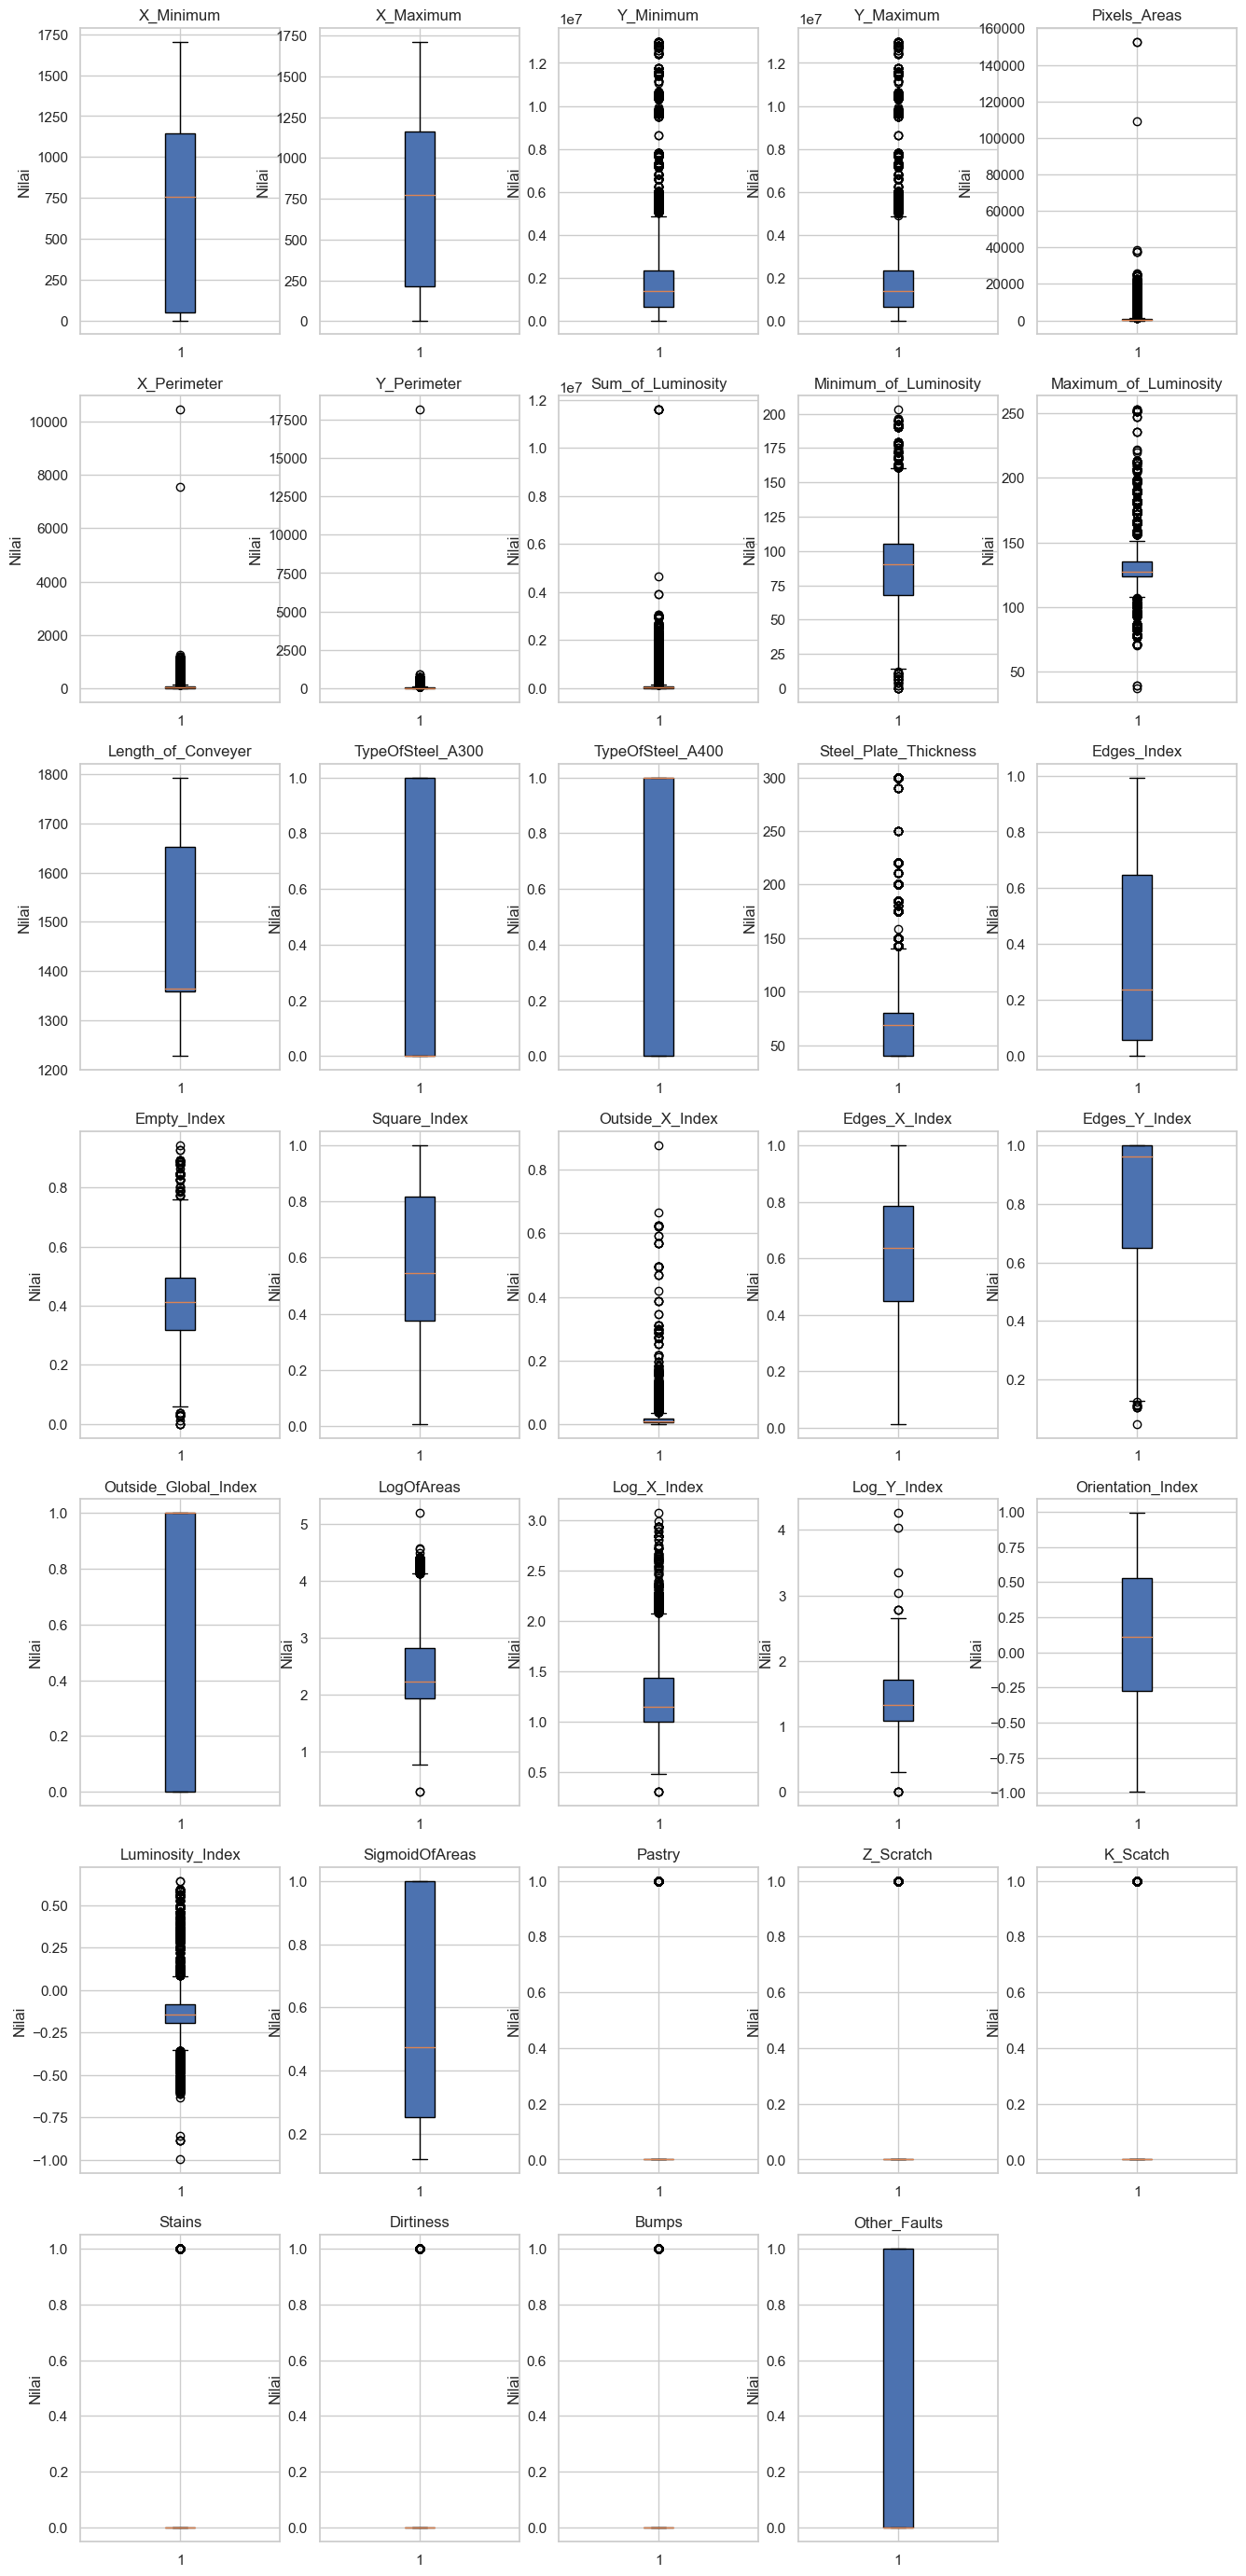

In [9]:
# Memilih kolom-kolom numerik
numeric_cols = train.select_dtypes(include=['float64', 'int64'])

# Menghitung jumlah subplot yang diperlukan
num_cols = len(numeric_cols.columns)
num_rows = int(np.ceil(num_cols / 5))  # Membagi jumlah kolom dengan 4 dan membulatkannya ke atas

# Membuat subplot dan boxplot untuk setiap kolom numerik
fig, axes = plt.subplots(num_rows, 5, figsize=(16, num_rows * 5))  # Mengatur ukuran subplot
fig.subplots_adjust(hspace=0.2)  # Mengatur jarak antar subplot

for i, column in enumerate(numeric_cols.columns):
    row = i // 5
    col = i % 5
    ax = axes[row, col]
    ax.boxplot(numeric_cols[column], patch_artist=True)
    ax.set_title(f'{column}')
    ax.set_ylabel('Nilai')

# Menghapus subplot yang tidak digunakan
for i in range(num_cols, num_rows * 5):
    row = i // 5
    col = i % 5
    fig.delaxes(axes[row, col])

plt.show()

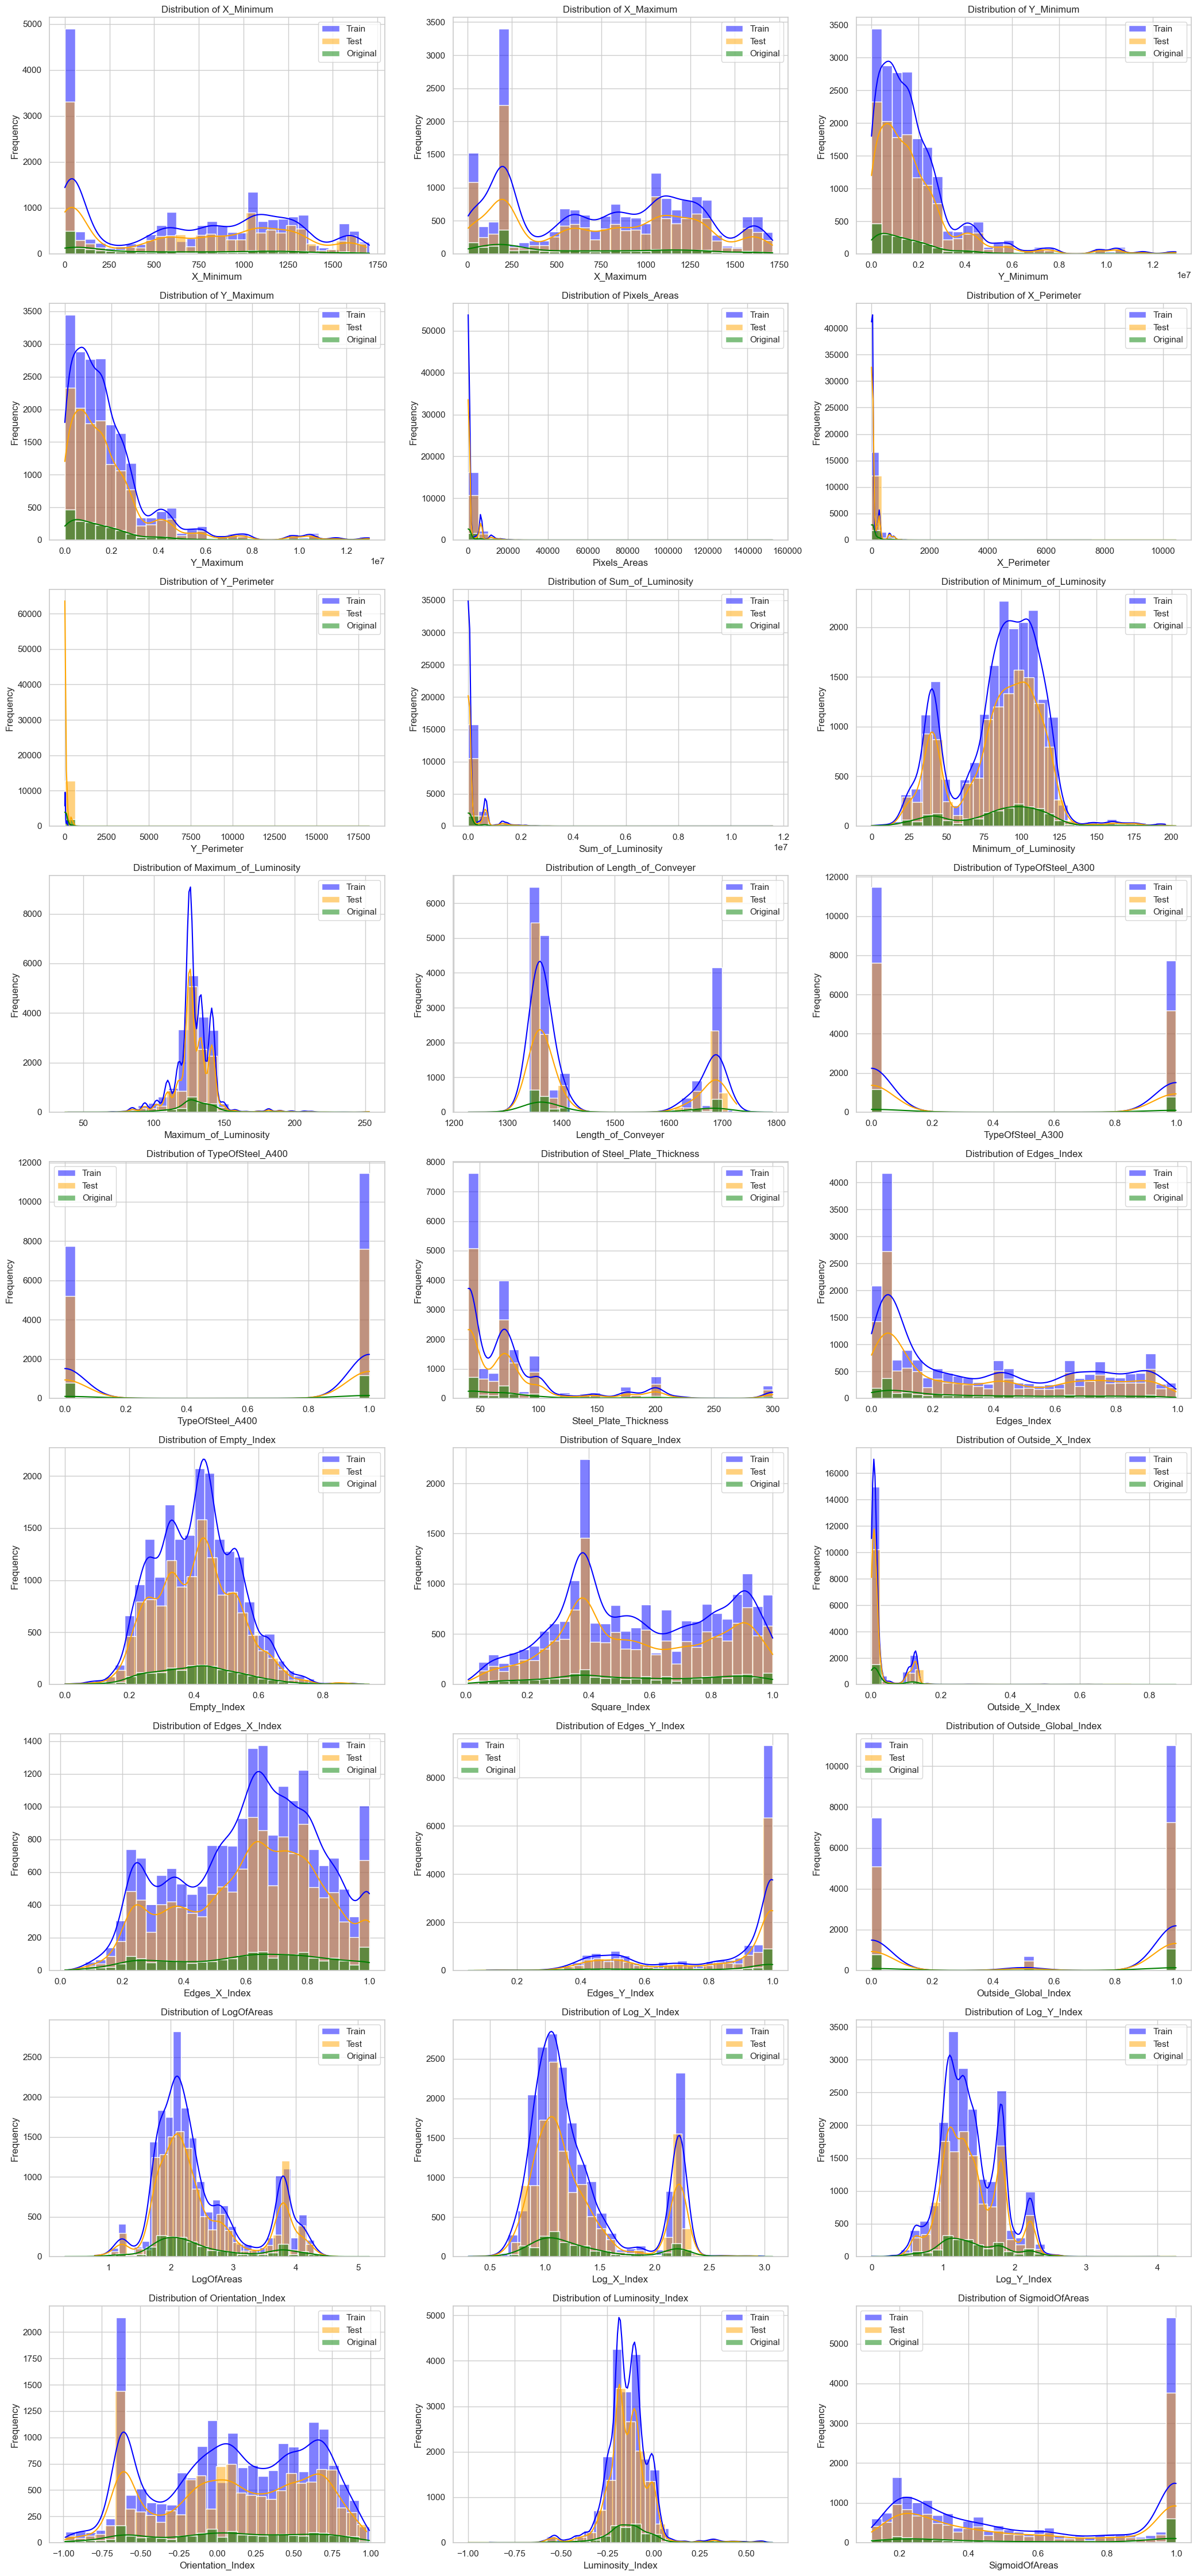

In [10]:
cont_cols = test.columns
colors = ['blue', 'orange', 'green']  

num_plots = len(cont_cols)
num_cols = 3  
num_rows = (num_plots + num_cols - 1) // num_cols  # Perhitungan jumlah baris yang lebih baik

# print(num_cols, num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(21, 5 * num_rows))  # Sesuaikan ukuran gambar sesuai kebutuhan

for i, feature in enumerate(cont_cols):
    # print(i)
    row = i // num_cols
    col = i % num_cols

    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    sns.histplot(train_copy[feature], kde=True, color=colors[0], label='Train', alpha=0.5, bins=30, ax=ax)
    sns.histplot(test_copy[feature], kde=True, color=colors[1], label='Test', alpha=0.5, bins=30, ax=ax)
    sns.histplot(original[feature], kde=True, color=colors[2], label='Original', alpha=0.5, bins=30, ax=ax)

    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.legend()

# Pastikan subplot yang tidak terpakai dinonaktifkan
if num_plots % num_cols != 0:
    for j in range(num_plots % num_cols, num_cols):
        axes[-1, j].axis('off')

plt.tight_layout()
plt.show()


In [11]:
# import sys 
# sys.exit(0)

# 4. Feature Engineering

In [12]:
def OHE(train_df, test_df, cols, target):
    combined = pd.concat([train_df, test_df], axis=0)
    
    for col in cols:
        one_hot = pd.get_dummies(combined[col]).astype(int)
        counts = combined[col].value_counts()
        min_count_category = counts.idxmin()
        one_hot = one_hot.drop(min_count_category, axis=1)
        one_hot.columns = [str(f) + col for f in one_hot.columns]
        combined = pd.concat([combined, one_hot], axis="columns")
        combined = combined.loc[:, ~combined.columns.duplicated()]
    
    # split back to train and test dataframes
    train_ohe = combined[:len(train_df)]
    test_ohe = combined[len(train_df):]
    test_ohe.reset_index(inplace=True, drop=True)
    test_ohe.drop(columns=[target], inplace=True)
    return train_ohe, test_ohe

# 4.1 Stabilize Categorical Columns

In [13]:
cat_cols = [f for f in test.columns if test[f].nunique() / test.shape[0] * 100 < 5 and test[f].nunique() > 2 ]
test[cat_cols].nunique()

def nearest_val(target):
    return min(common, key=lambda x: abs(x - target))

global cat_cols_updated
cat_cols_updated = []
for col in cat_cols:
    train[f"{col}_cat"] = train[col]
    test[f"{col}_cat"] = test[col]
    cat_cols_updated.append(f"{col}_cat")
    uncommon = list((set(test[col].unique()) | set(train[col].unique())) - (set(test[col].unique()) & set(train[col].unique())))
    if uncommon:
        common = list(set(test[col].unique()) & set(train[col].unique()))
        train[f"{col}_cat"] = train[col].apply(nearest_val)
        test[f"{col}_cat"] = test[col].apply(nearest_val)

In [14]:
def high_freq_ohe(train, test, extra_cols, target, n_limit=50):
    '''
    If you wish to apply one hot encoding on a feature with so many unique values, then this can be applied, 
    where it takes a maximum of n categories and drops the rest of them treating as rare categories
    '''
    train_copy = train.copy()
    test_copy = test.copy()
    ohe_cols = []
    for col in extra_cols:
        dict1 = train_copy[col].value_counts().to_dict()
        ordered = dict(sorted(dict1.items(), key=lambda x: x[1], reverse=True))
        rare_keys = list([*ordered.keys()][n_limit:])
#         ext_keys=[f[0] for f in ordered.items() if f[1]<50]
        rare_key_map = dict(zip(rare_keys, np.full(len(rare_keys), 9999)))
        
        train_copy[col] = train_copy[col].replace(rare_key_map)
        test_copy[col] = test_copy[col].replace(rare_key_map)
        
    train_copy, test_copy = OHE(train_copy, test_copy, extra_cols, target)
    drop_cols = [f for f in train_copy.columns if "9999" in f or train_copy[f].nunique() == 1]
    train_copy = train_copy.drop(columns=drop_cols)
    test_copy = test_copy.drop(columns=drop_cols)
    
    return train_copy, test_copy


In [15]:
def cat_encoding(train, test, target):
    global overall_best_score
    global overall_best_col
    
    table = PrettyTable()
    table.field_names = ['Feature', 'Encoded Features', 'Log Loss Score']
    
    train_copy=train.copy()
    test_copy=test.copy()
    train_dum = train.copy()
    
    for feature in cat_cols_updated:
        dic = train[feature].value_counts().to_dict()
        train_copy[feature + "_count"] = train[feature].map(dic)
        test_copy[feature + "_count"] = test[feature].map(dic)

        dic2 = train[feature].value_counts().to_dict()
        list1 = np.arange(len(dic2.values())) # Higher rank for low count
        dic3 = dict(zip(list(dic2.keys()), list1))
        
        train_copy[feature+"_count_label"] = train[feature].replace(dic3).astype(float)
        test_copy[feature+"_count_label"] = test[feature].replace(dic3).astype(float)

        temp_cols = [ feature + "_count", feature + "_count_label"] #feature + "_target",

        

        if train_copy[feature].nunique() <= 5:
            train_copy[feature] = train_copy[feature].astype(str) + "_" + feature
            test_copy[feature] = test_copy[feature].astype(str) + "_" + feature
            train_copy, test_copy = OHE(train_copy, test_copy, [feature], target)
        else:
            train_copy, test_copy = high_freq_ohe(train_copy, test_copy, [feature], target, n_limit=5)
        train_copy = train_copy.drop(columns=[feature])
        test_copy = test_copy.drop(columns=[feature])
        
        
        kf = KFold(n_splits=5, shuffle=True, random_state=42)

        auc_scores = []

        for f in temp_cols:
            X = train_copy[[f]].values
            y = train_copy[target].astype(int).values

            auc = []
            for train_idx, val_idx in kf.split(X, y):
                X_train, y_train = X[train_idx], y[train_idx]
                x_val, y_val = X[val_idx], y[val_idx]
                model =  HistGradientBoostingClassifier (max_iter=300, learning_rate=0.02, max_depth=6, random_state=42)
                model.fit(X_train, y_train)
                y_pred = model.predict_proba(x_val)[:,1]
                auc.append(roc_auc_score(y_val,  y_pred))
            auc_scores.append((f, np.mean(auc)))
            
        best_col, best_auc = sorted(auc_scores, key=lambda x: x[1], reverse=True)[0]

        corr = train_copy[temp_cols].corr(method='pearson')
        corr_with_best_col = corr[best_col]
        cols_to_drop = [f for f in temp_cols if corr_with_best_col[f] > 0.5 and f != best_col]
        final_selection = [f for f in temp_cols if f not in cols_to_drop]
        if cols_to_drop:
            train_copy = train_copy.drop(columns=cols_to_drop)
            test_copy = test_copy.drop(columns=cols_to_drop)

        table.add_row([feature, best_col, best_auc])

    return train_copy, test_copy

# Modeling

### 5.1 Models

In [16]:
class Splitter:
    def __init__(self, test_size=0.2, kfold=True, n_splits=5):
        self.test_size = test_size
        self.kfold = kfold
        self.n_splits = n_splits

    def split_data(self, X, y, random_state_list):
        if self.kfold:
            for random_state in random_state_list:
                kf = KFold(n_splits=self.n_splits, random_state=random_state, shuffle=True)
                for train_index, val_index in kf.split(X, y):
                    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
                    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
                    yield X_train, X_val, y_train, y_val

class Classifier:
    def __init__(self,n_estimators=100, device="cpu", random_state=0):
        self.n_estimators = n_estimators
        self.device = device
        self.random_state = random_state
        self.models = self._define_model()
        self.len_models = len(self.models)
        
    def _define_model(self):
        xgb_params = {
            'n_estimators': self.n_estimators,
            'learning_rate': 0.1,
            'max_depth': 4,
            'subsample': 0.8,
            'colsample_bytree': 0.1,
            'n_jobs': -1,
            'eval_metric': 'logloss',
            'objective': 'binary:logistic',
            'tree_method': 'hist',
            'verbosity': 0,
            'random_state': self.random_state,
        }
        if self.device == 'gpu':
            xgb_params['tree_method'] = 'gpu_hist'
            xgb_params['predictor'] = 'gpu_predictor'

        cb_params = {
            'iterations': self.n_estimators,
            'depth': 13,
            'learning_rate': 0.015,
            'l2_leaf_reg': 0.5,
            'random_strength': 0.1,
            'max_bin': 200,
            'od_wait': 65,
            'one_hot_max_size': 50,
            'grow_policy': 'Depthwise',
            'bootstrap_type': 'Bernoulli',
            'od_type': 'Iter',
            'eval_metric': 'AUC',
            'loss_function': 'Logloss',
            'task_type': self.device.upper(),
            'random_state': self.random_state,
        }
        
        cb_sym_params = cb_params.copy()
        cb_sym_params['grow_policy'] = 'SymmetricTree'
        
        models = {
            'xgb': xgb.XGBClassifier(**xgb_params),
            'cat': CatBoostClassifier(**cb_params),
            "cat_sym": CatBoostClassifier(**cb_sym_params),                                       
        }
        return models

### 5.2 Optimize Ensemble Weights

In [17]:
class OptunaWeights:
    def __init__(self, random_state, n_trials=5000):
        self.study = None
        self.weights = None
        self.random_state = random_state
        self.n_trials = n_trials

    def _objective(self, trial, y_true, y_preds):
        weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))]
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=weights)

        auc_score = roc_auc_score(y_true, weighted_pred)
        log_loss_score = log_loss(y_true, weighted_pred)
        return auc_score

    def fit(self, y_true, y_preds):
        optuna.logging.set_verbosity(optuna.logging.ERROR)
        sampler = optuna.samplers.CmaEsSampler(seed=self.random_state)
        pruner = optuna.pruners.HyperbandPruner()
        self.study = optuna.create_study(sampler=sampler, pruner=pruner, study_name="OptunaWeights", direction='maximize')
        objective_partial = partial(self._objective, y_true=y_true, y_preds=y_preds)
        self.study.optimize(objective_partial, n_trials=self.n_trials)
        self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]

    def predict(self, y_preds):
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict'
        weighted_pred = np.average(np.array(y_preds).T, axis=1, weights=self.weights)
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights

### 5.3 Fit The Model

In [18]:
def fit_model(X_train,X_test,y_train):
    kfold = True
    n_splits = 1 if not kfold else 5
    random_state = 2023
    random_state_list = [42] # used by split_data [71]
    n_estimators = 9999 # 9999
    early_stopping_rounds = 300
    verbose = False

    splitter = Splitter(kfold=kfold, n_splits=n_splits)

    # Initialize an array for storing test predictions
    test_predss = np.zeros(X_test.shape[0])
    y_train_pred = y_train.copy()

    ensemble_score = []
    weights = []
    trained_models = {'xgb':[], 'lgb':[]}


    for i, (X_train_, X_val, y_train_, y_val) in enumerate(splitter.split_data(X_train, y_train, random_state_list=random_state_list)):
        n = i % n_splits
        m = i // n_splits

        # Get a set of Regressor models
        classifier = Classifier(n_estimators, device, random_state)
        models = classifier.models

        # Initialize lists to store oof and test predictions for each base model
        oof_preds = []
        test_preds = []

        # Loop over each base model and fit it to the training data, evaluate on validation data, and store predictions
        for name, model in models.items():
            if ('cat' in name) or ("lgb" in name) or ("xgb" in name):
                if 'lgb' in name: #categorical_feature=cat_features
                    model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)]),#,categorical_feature=cat_features,)
                elif 'cat' in name:
                    model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)],#cat_features=cat_features,
                              early_stopping_rounds=early_stopping_rounds, verbose=verbose)
                else:
                    model.fit(X_train_, y_train_, eval_set=[(X_val, y_val)], early_stopping_rounds=early_stopping_rounds, verbose=0)
            else:
                model.fit(X_train_, y_train_)

            test_pred = model.predict_proba(X_test)[:, 1]
            y_val_pred = model.predict_proba(X_val)[:, 1]

            score = roc_auc_score(y_val, y_val_pred.reshape(-1, 1))
    #         score = accuracy_score(y_val, acc_cutoff_class(y_val, y_val_pred))

            print(f'{name} [FOLD-{n} SEED-{random_state_list[m]}] ROC AUC score: {score:.5f}')

            oof_preds.append(y_val_pred)
            test_preds.append(test_pred)

            if name in trained_models.keys():
                trained_models[f'{name}'].append(deepcopy(model))
        # Use Optuna to find the best ensemble weights
        optweights = OptunaWeights(random_state=random_state)
        y_val_pred = optweights.fit_predict(y_val.values, oof_preds)

        score = roc_auc_score(y_val, y_val_pred.reshape(-1, 1))
    #     score = accuracy_score(y_val, acc_cutoff_class(y_val, y_val_pred))
        print(f'Ensemble [FOLD-{n} SEED-{random_state_list[m]}] ------------------>  ROC AUC score {score:.5f}')
        ensemble_score.append(score)
        weights.append(optweights.weights)

        test_predss += optweights.predict(test_preds) / (n_splits * len(random_state_list))
        y_train_pred.loc[y_val.index] = np.array(y_val_pred)

        gc.collect()
    # Calculate the mean ROC AUC  score of the ensemble
    mean_score = np.mean(ensemble_score)
    std_score = np.std(ensemble_score)
    print(f'Ensemble ROC AUC score {mean_score:.5f} ± {std_score:.5f}')

    # Print the mean and standard deviation of the ensemble weights for each model
    print('--- Model Weights ---')
    mean_weights = np.mean(weights, axis=0)
    std_weights = np.std(weights, axis=0)
    for name, mean_weight, std_weight in zip(models.keys(), mean_weights, std_weights):
        print(f'{name}: {mean_weight:.5f} ± {std_weight:.5f}')
    print(f'Overall OOF Preds AUC SCORE {roc_auc_score(y_train,y_train_pred)}')
    
    print("__________________________________________________________________")
    return test_predss

In [19]:
def post_processor(train, test):
    cols = test.columns.tolist()
    train_cop = train.copy()
    test_cop = test.copy()
    drop_cols = []
    for i, feature in enumerate(cols):
        for j in range(i+1, len(cols)):
            if sum(abs(train_cop[feature] - train_cop[cols[j]])) == 0:
                if cols[j] not in drop_cols:
                    drop_cols.append(cols[j])
    print(drop_cols)
    train_cop.drop(columns=drop_cols, inplace=True)
    test_cop.drop(columns=drop_cols, inplace=True)
    
    return train_cop, test_cop


In [20]:
submission=pd.read_csv("data/sample_submission.csv")
submission.head()

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,19220,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,19221,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,19222,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,19223,0.5,0.5,0.5,0.5,0.5,0.5,0.5


In [21]:
count=0
for col in target:
    train_temp = train[test.columns.tolist() + [col]]
    test_temp = test.copy()
    train_temp, test_temp = cat_encoding(train_temp, test_temp, col)
    
    final_features = test.columns.tolist()
    sc = StandardScaler()

    train_scaled = train_temp.copy()
    test_scaled = test_temp.copy()
    
    train_scaled[final_features] = sc.fit_transform(train[final_features])
    test_scaled[final_features] = sc.transform(test[final_features])

#     train_cop, test_cop=   post_processor(train_scaled, test_scaled) 
    train_cop, test_cop = train_scaled, test_scaled
    X_train = train_cop.drop(columns=[col])
    y_train = train_cop[col]
    
    X_test = test_cop.copy()
    
    test_predss = fit_model(X_train,X_test,y_train)
    submission[col] = test_predss
    
    count += 1
    print(f'Column {col}, loop # {count}')

KeyboardInterrupt: 

In [ ]:
submission.to_csv("submission_pure.csv",index=False)
submission.head()

# 7. Generalization Ensemble

In [24]:
sub1 = pd.read_csv("submission/my_submission.csv")
# sub2 = pd.read_csv("/kaggle/input/ps4e03-multi-class-lightgbm/submission.csv")
submission = pd.read_csv("submission/submission_pure.csv")
sub_list = [sub1, submission]
# weights=np.random.randint(1,4,len(sub_list))
weights = [10, 7]

weighted_list = [item for sublist, weight in zip(sub_list, weights) for item in [sublist] * weight]

def ensemble_mean(sub_list, cols, mean="AM"):
    
    sub_out = sub_list[0].copy()
    if mean == "AM":
        for col in cols:
            sub_out[col] = sum(df[col] for df in sub_list)/len(sub_list)
    elif mean == "GM":
        for df in sub_list[1:]:

            for col in cols:
                sub_out[col] *= df[col]
        for col in cols:
            sub_out[col] = (sub_out[col]) ** (1/len(sub_list))
    elif mean == "HM":
        for col in cols:
            sub_out[col] = len(sub_list) / sum(1/df[col] for df in sub_list)
    sub_out[cols] = sub_out[cols].div(sub_out[cols].sum(axis=1), axis=0)
    
    return sub_out
    
sub_ensemble = ensemble_mean(weighted_list, target, mean="AM")
sub_ensemble.to_csv('submission-ensemble.csv',index=False)
sub_ensemble.head()

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults,id
0,0.513196,0.002036,0.004512,0.012370,0.014452,0.134620,0.318816,19219
1,0.267764,0.022268,0.012649,0.016541,0.121768,0.154618,0.404391,19220
2,0.003544,0.037032,0.039001,0.019136,0.007507,0.333344,0.560434,19221
3,0.108493,0.003843,0.002590,0.018390,0.012401,0.399522,0.454760,19222
4,0.004848,0.003489,0.002937,0.020085,0.006501,0.628342,0.333799,19223
